# Feed Forward Neural Network 

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import scanpy as sc
import os
from numpy.random import seed
# from tensorflow import set_random_seed
import warnings
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from scipy.stats import rankdata
# from fancyimpute import IterativeImputer

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
warnings.filterwarnings("ignore")

In [9]:
adata_train=sc.read('/content/drive/MyDrive/Shared resources/Bh.h5ad')
adata_test=sc.read('/content/drive/MyDrive/Shared resources/smartseq2.h5ad')

In [10]:
len(adata_train.obs["celltype"])

8569

In [11]:
#/Utils/preprocess.py
def preprocess(adata_test, min_genes = 200, min_cells = 20, target_sum = 1e6, n_top_genes = 3000, max_value = 10, get_hvgs=False, scale_and_hvgs = False):
        """
        INPUT:
        file_path: path to .h5ad containing scRNA-seq
        """
        ## convert to h5ad
        # adata_test = sc.AnnData(genes, labels)

        ## make var names unique
        adata_test.obs_names_make_unique()
        adata_test.var_names_make_unique()

    ## filter cells with count less than 200
        sc.pp.filter_cells(adata_test, min_genes=min_genes)

        ## filter genes with count less than 20
        sc.pp.filter_genes(adata_test, min_cells=min_cells)

        ## normalise data
        sc.pp.normalize_total(adata_test, target_sum=target_sum)

        ## LogNormalise
        if not(scale_and_hvgs):
                return {'data':adata_test}

        if get_hvgs:
                ## Get HVGS
                sc.pp.log1p(adata_test)
                sc.pp.highly_variable_genes(adata_test, n_top_genes = n_top_genes)
                adata_test = adata_test[:, adata_test.var.highly_variable]

                ## scale data
                sc.pp.scale(adata_test, max_value=max_value)
                return {'data' : adata_test, 'hvg': adata_test.var.highly_variable}

        ## scale data
        sc.pp.scale(adata_test, max_value=max_value)
        return {'data':adata_test}

In [24]:
print("Starting preprocessing...")
train_dic = preprocess(adata_train, min_cells=20,min_genes=50, get_hvgs = True, scale_and_hvgs = True)
test_dic = preprocess(adata_test, min_cells=0, min_genes=0)

Starting preprocessing...


In [25]:
train_adata_pp =  train_dic['data']
test_adata_pp =  test_dic['data']

In [26]:
train_df = train_adata_pp.to_df()
test_df = test_adata_pp.to_df()

In [27]:
## taking common genes
print("Taking common genes...")
final_columns = list(set(train_df.columns).intersection(set(test_df.columns)))
print('Common columns', len(final_columns))
final_columns = [i for i in final_columns if i != 'celltype'] 
train_df = train_df[final_columns]
test_df = test_df[final_columns]

Taking common genes...
Common columns 2975


In [31]:
y_train = train_adata_pp.obs.celltype.to_list()
y_test = test_adata_pp.obs.celltype.to_list()

In [32]:
# count of celltypes in test data
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{'acinar': 188,
 'activated_stellate': 55,
 'alpha': 1008,
 'beta': 308,
 'delta': 127,
 'ductal': 444,
 'endothelial': 21,
 'epsilon': 8,
 'gamma': 213,
 'macrophage': 7,
 'mast': 7,
 'quiescent_stellate': 6,
 'schwann': 2}

In [33]:
# count of celltypes in train data
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'acinar': 958,
 'activated_stellate': 284,
 'alpha': 2326,
 'beta': 2525,
 'delta': 601,
 'ductal': 1077,
 'endothelial': 252,
 'epsilon': 18,
 'gamma': 255,
 'macrophage': 55,
 'mast': 25,
 'quiescent_stellate': 173,
 'schwann': 13,
 't_cell': 7}

In [34]:
print(len(y_train))
print(len(y_test))

8569
2394


Rank Transform

In [35]:
def rank_transform(feats):
        '''converts features to ranks'''
        rows = []
        cols = list(feats.columns)
#       ind = list(feats.index)
        for ind in feats.index.to_list():
                c_r = []
                for col in cols:
                        c_r.append(feats.loc[ind,col])
                rows.append([int(x) for x in rankdata(c_r)])
        feats = pd.DataFrame(rows)
        feats.columns = cols
#       feats.index = ind
        return feats

In [36]:
train_df

index,CELF2,MLPH,TRO,LIN52,LGALS2,MUC13,TP53I11,BTK,CCDC34,CNKSR2,...,ARL4C,PCDHA10,POSTN,ALOXE3,CMAHP,PPM1F,ETS2,FARS2,TM6SF1,CCL3L3
index,,,,,,,,,,,,,,,,,,,,,
human1_lib1.final_cell_0001,-0.207448,-0.208074,-0.228877,-0.201055,4.470813,-0.566172,-0.418833,-0.062274,-0.247703,-0.149153,...,-0.399250,-0.097965,-0.095955,-0.055949,-0.050413,-0.253693,0.928419,3.765541,-0.057885,-0.051224
human1_lib1.final_cell_0002,-0.207448,-0.208074,-0.228877,-0.201055,5.179790,-0.566172,1.384101,-0.062274,-0.247703,-0.149153,...,-0.399250,7.254989,-0.095955,-0.055949,-0.050413,2.569694,1.269408,-0.263793,-0.057885,-0.051224
human1_lib1.final_cell_0003,-0.207448,-0.208074,-0.228877,-0.201055,-0.209556,-0.566172,-0.418833,-0.062274,-0.247703,-0.149153,...,-0.399250,-0.097965,-0.095955,-0.055949,-0.050413,-0.253693,1.307822,-0.263793,-0.057885,-0.051224
human1_lib1.final_cell_0004,-0.207448,-0.208074,-0.228877,-0.201055,4.804120,0.812671,-0.418833,-0.062274,-0.247703,-0.149153,...,-0.399250,-0.097965,-0.095955,-0.055949,-0.050413,-0.253693,1.747672,-0.263793,-0.057885,-0.051224
human1_lib1.final_cell_0005,-0.207448,-0.208074,-0.228877,-0.201055,-0.209556,-0.566172,-0.418833,-0.062274,-0.247703,-0.149153,...,-0.399250,-0.097965,-0.095955,-0.055949,-0.050413,-0.253693,-0.580574,-0.263793,-0.057885,-0.051224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
human4_lib3.final_cell_0697,5.550322,-0.208074,-0.228877,-0.201055,-0.209556,-0.566172,-0.418833,-0.062274,-0.247703,-0.149153,...,3.022738,-0.097965,-0.095955,-0.055949,-0.050413,-0.253693,-0.580574,-0.263793,-0.057885,-0.051224
human4_lib3.final_cell_0698,6.230207,-0.208074,-0.228877,-0.201055,-0.209556,-0.566172,-0.418833,-0.062274,-0.247703,-0.149153,...,2.695696,-0.097965,-0.095955,-0.055949,-0.050413,4.606681,-0.580574,-0.263793,-0.057885,-0.051224
human4_lib3.final_cell_0699,-0.207448,-0.208074,-0.228877,-0.201055,-0.209556,-0.566172,-0.418833,-0.062274,-0.247703,-0.149153,...,-0.399250,-0.097965,-0.095955,-0.055949,-0.050413,-0.253693,-0.580574,-0.263793,-0.057885,-0.051224


In [37]:
train_rank = rank_transform(train_df)

In [38]:
X_train = train_rank.to_numpy()
# X_test = test_df.to_numpy()

In [39]:
number_of_layers = list(range(2,6))
hidden_sizes = 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Create model object
# clf = MLPClassifier(hidden_layer_sizes=( 1000 , 600 ,  400  , 250   , 150   , 100 , 70  , 20 ),
#                     random_state=5,
#                     verbose=True,
#                     learning_rate_init=0.01)

mlpg = MLPClassifier(max_iter = 10)
parameters = {'activation':('identity','logistic','tanh','relu'), 'learning_rate_init':[0.1,0.01,0.001], 'hidden_layer_sizes' : [( 1000,600,400,250,150,100,70,20)],
              'batch_size' :[128,256]}
gs = GridSearchCV(mlpg,parameters,cv = 3, scoring = 'neg_log_loss', verbose = 1)
gs.fit(X_train,y_train)

# Fit data onto the model
# clf.fit(X_train,y_train)

# loss=1.89 approx

Fitting 3 folds for each of 84 candidates, totalling 252 fits


In [ ]:
test_rank = rank_transform(test_df)

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create model object
clf = MLPClassifier(hidden_layer_sizes=( 1000 , 600 ,  400  , 250   , 150   , 100 , 70  , 20 ),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01,
                    max_iter = 10)

# Fit data onto the model
clf.fit(X_train,y_train)

# loss=1.89 approx

Iteration 1, loss = 8.49514851
Iteration 2, loss = 6.38097813
Iteration 3, loss = 2.17286648
Iteration 4, loss = 2.07544355
Iteration 5, loss = 2.01687856
Iteration 6, loss = 1.97994890
Iteration 7, loss = 1.95918874
Iteration 8, loss = 1.94407498
Iteration 9, loss = 1.93466418
Iteration 10, loss = 1.92810169


MLPClassifier(hidden_layer_sizes=(1000, 600, 400, 250, 150, 100, 70, 20),
              learning_rate_init=0.01, max_iter=10, random_state=5,
              verbose=True)

In [ ]:
y_pred = clf.predict(test_rank)

In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{'alpha': 2394}

In [ ]:
# Import accuracy score 
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.42105263157894735

In [ ]:
## class wise accuracy 

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
acc = cm.diagonal()
acc = acc*100

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
unique

array(['acinar', 'activated_stellate', 'alpha', 'beta', 'delta', 'ductal',
       'endothelial', 'epsilon', 'gamma', 'macrophage', 'mast',
       'quiescent_stellate', 'schwann'], dtype='<U18')

<BarContainer object of 13 artists>

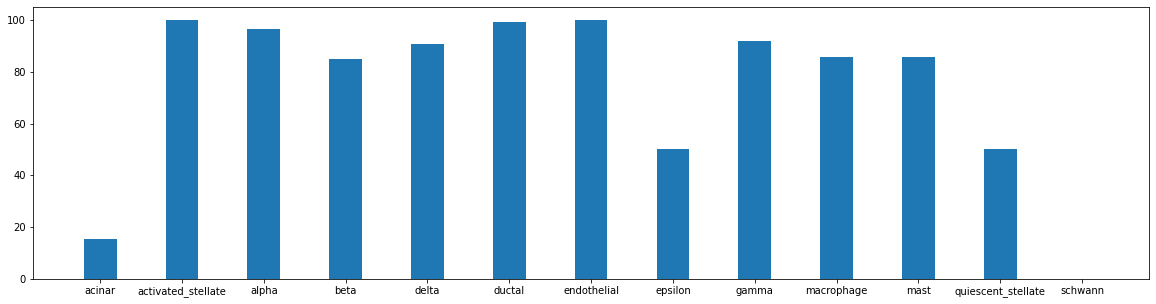

In [ ]:
fig = plt.figure(figsize = (20, 5))
plt.bar(unique,acc,width = 0.4)

## Result


Accuracy Score came out to be approximately 88.22 %